In [2]:
# Data manipulation ---------------------------------------------------------------------------------------------

import pandas as pd
import numpy as np

# RandomForestRegressor for Demand Prediction -------------------------------------------------------------------

from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from datetime import datetime, timedelta

# Data Visualization

import matplotlib.pyplot as plt
import seaborn as sns

# Warnings ------------------------------------------------------------------------------------------------------

import warnings
warnings.filterwarnings('ignore')

## Make function

In [3]:
def clean_day(year, m, m_df, day, station, demand):
    
    grouped_days = m_df.groupby(m_df['Inicio_del_viaje'].dt.day)
    
    day_n = grouped_days.get_group(day)
    month = pd.DataFrame()

    if demand == 'negative':
        dema = 'Origen_Id'
    elif demand == 'positive':
        dema = 'Destino_Id'
        
    day_n_station_n = day_n.loc[day_n[dema] == station]

    hourly_counts = day_n_station_n.groupby(day_n_station_n['Inicio_del_viaje'].dt.hour)['Inicio_del_viaje'].count()

    hours_range = pd.Series(range(0, 24))

    hourly_counts = hourly_counts.reindex(hours_range, fill_value = 0)

    #hourly_counts
    month = pd.concat([month, hourly_counts])

    month_df = pd.DataFrame()

    month_df['Hour'] = list(month.index)

    month_df['Count'] = list(map(int, list(month.values)))
    
    d = str(day)
    if len(d) < 2:
        d = '0' + d
        
    m = str(m)
    if len(m) < 2:
        m = '0' + m
        
    fecha = str(year) +'-'+ m +'-'+ d
    
    horas_datetime = pd.to_datetime(fecha) + pd.to_timedelta(month_df.Hour, unit='h')
    
    month_df['Hour'] = horas_datetime

    return month_df

In [4]:
def clean_month(year, m, m_df,station, demand):
    days = {1:31,
            2:28,
            3:31,
            4:30,
            5:31,
            6:30,
            7:31,
            8:31,
            9:30,
            10:31,
            11:30,
            12:31}
    
    total_month = pd.DataFrame()
    for day in range(1, days[m]+1):
        total_month = pd.concat([total_month, clean_day(year, m, m_df, day, station, demand)])
        
    return total_month

## Hacer el merge

In [5]:
def historic_per_year(year, station, demand):
    data_total = pd.DataFrame()

    for m in range(1,10): # menos en 2023
        mes = m
        m = str(m)
        if len(m) < 2:
            m = '0' + m

        m_df = pd.read_csv('data/datos_abiertos_' + str(year) + '_'+ m +'.csv', encoding='iso-8859-1')
        m_df['Inicio_del_viaje'] = pd.to_datetime(m_df['Inicio_del_viaje'])

        data_total = pd.concat([data_total, clean_month(year, mes, m_df,station, demand)])
        
    return data_total

In [ ]:
year = 2022
station = 49
demand = 'positive'
historic_per_year(year, station, demand)
data_total

In [5]:
year = 2023
station = 49
demand = 'positive'
ye2023 = historic_per_year(year, station, demand)

In [42]:
year = 2023
station = 49
demand = 'negative'
ye2023_negative = historic_per_year(year, station, demand)

In [6]:
station = 49
demand = 'positive'

def demand_df(station, demand):
    demand_df = pd.DataFrame()
    for year in range(2020, 2023):
        demand_df = pd.concat([demand_df, historic_per_year(year, station, demand)])
    return demand_df

In [7]:
df = demand_df(station, demand)

In [43]:
df2 = demand_df(station, 'negative')

In [32]:
m = positive_49[:].reset_index()

In [33]:
m = m[['Hour', 'Count']]

In [34]:
m

,Hour,Count
0,2020-01-01 00:00:00,0
1,2020-01-01 01:00:00,0
2,2020-01-01 02:00:00,0
3,2020-01-01 03:00:00,0
4,2020-01-01 04:00:00,0
...,...,...
19651,2022-09-30 19:00:00,7
19652,2022-09-30 20:00:00,7
19653,2022-09-30 21:00:00,3
19654,2022-09-30 22:00:00,4


In [19]:
def metrics(df):
    def evaluate_performance(y_true, y_pred):
        mae = mean_absolute_error(y_true, y_pred)
        mse = mean_squared_error(y_true, y_pred)
        rmse = np.sqrt(mse)

        print(f'Mean Absolute Error (MAE): {mae}')
        print(f'Mean Squared Error (MSE): {mse}')
        print(f'Root Mean Squared Error (RMSE): {rmse}')
        return

    df['Hour'] = pd.to_datetime(df['Hour'])

    # Extract features from the datetime column
    df['HourOfDay'] = df['Hour'].dt.hour
    df['DayOfWeek'] = df['Hour'].dt.dayofweek
    df['DayOfYear'] = df['Hour'].dt.dayofyear


    X = df[['HourOfDay', 'DayOfWeek', 'DayOfYear']]
    y = df['Count']

    # Train model --------------------------------------------------------------------------------------------------

    # Split data
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=3)

    # Create a RandomForestRegressor model
    rf_model = RandomForestRegressor(n_estimators=100, random_state=3)

    # Train the model
    rf_model.fit(X_train, y_train)

    # Evaluate performance on the training set
    train_predictions = rf_model.predict(X_train)
    print("Training Set Performance:")
    evaluate_performance(y_train, train_predictions)

    # Evaluate performance on the test set
    test_predictions = rf_model.predict(X_test)
    print("\nTest Set Performance:")
    evaluate_performance(y_test, test_predictions)
    
    return 

In [20]:
metrics(df)

Training Set Performance:
Mean Absolute Error (MAE): 0.44571991859577714
Mean Squared Error (MSE): 0.47794283897227163
Root Mean Squared Error (RMSE): 0.6913341008313358

Test Set Performance:
Mean Absolute Error (MAE): 1.2116327568667344
Mean Squared Error (MSE): 3.399506917599186
Root Mean Squared Error (RMSE): 1.8437751808718943


In [45]:
def demand(df):

    df['Hour'] = pd.to_datetime(df['Hour'])

    # Extract features from the datetime column
    df['HourOfDay'] = df['Hour'].dt.hour
    df['DayOfWeek'] = df['Hour'].dt.dayofweek
    df['DayOfYear'] = df['Hour'].dt.dayofyear

    # Assuming 'Count' is the target variable
    X = df[['HourOfDay', 'DayOfWeek', 'DayOfYear']]
    y = df['Count']

    # Train model --------------------------------------------------------------------------------------------------

    # Split data
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=3)

    # Create a RandomForestRegressor model
    rf_model = RandomForestRegressor(n_estimators=100, random_state=3)

    # Train the model
    rf_model.fit(X_train, y_train)

    # Make predictions for the year 2023 ---------------------------------------------------------------------------

    start_date = datetime(2023, 1, 1, 0, 0, 0)
    end_date = datetime(2023, 12, 31, 23, 0, 0)
    date_range = pd.date_range(start=start_date, end=end_date, freq='H')

    prediction_df = pd.DataFrame({'Hour': date_range})
    prediction_df['HourOfDay'] = prediction_df['Hour'].dt.hour
    prediction_df['DayOfWeek'] = prediction_df['Hour'].dt.dayofweek
    prediction_df['DayOfYear'] = prediction_df['Hour'].dt.dayofyear

    # Predictions --------------------------------------------------------------------------------------------------

    predictions = rf_model.predict(prediction_df[['HourOfDay', 'DayOfWeek', 'DayOfYear']])

    prediction_df['PredictedCount'] = predictions

    prediction_df = prediction_df[['Hour', 'PredictedCount']]

    predicted = pd.DataFrame()

    predicted['Hour'] = prediction_df['Hour']
    predicted['Count'] = np.round(prediction_df['PredictedCount'])

    return predicted

In [13]:


def arbol(df):
    df['Hour'] = pd.to_datetime(df['Hour'])
    df['HourOfDay'] = df['Hour'].dt.hour
    df['DayOfWeek'] = df['Hour'].dt.dayofweek
    df['DayOfYear'] = df['Hour'].dt.dayofyear

    X = df[['HourOfDay', 'DayOfWeek', 'DayOfYear']]
    y = df['Count']

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=3)

    rf_model = RandomForestRegressor(n_estimators=100, random_state=3)
    rf_model.fit(X_train, y_train)

    # Visualizar un árbol de decisión individual
    tree = rf_model.estimators_[0]  # Selecciona el primer árbol del bosque
    feature_names = list(X.columns)

    # Texto del árbol
    tree_text = export_text(tree, feature_names=feature_names)
    print("Árbol de Decisión:\n", tree_text)

    # Visualización gráfica del árbol
    plt.figure(figsize=(12, 8))
    plot_tree(tree, feature_names=feature_names, filled=True, rounded=True)
    plt.show()

    
    return 


In [14]:
arbol(df)

Árbol de Decisión:
 |--- HourOfDay <= 7.50
|   |--- HourOfDay <= 6.50
|   |   |--- HourOfDay <= 5.50
|   |   |   |--- HourOfDay <= 0.50
|   |   |   |   |--- DayOfYear <= 171.50
|   |   |   |   |   |--- DayOfYear <= 32.50
|   |   |   |   |   |   |--- DayOfWeek <= 5.50
|   |   |   |   |   |   |   |--- DayOfYear <= 12.50
|   |   |   |   |   |   |   |   |--- value: [0.00]
|   |   |   |   |   |   |   |--- DayOfYear >  12.50
|   |   |   |   |   |   |   |   |--- DayOfYear <= 13.50
|   |   |   |   |   |   |   |   |   |--- DayOfWeek <= 1.50
|   |   |   |   |   |   |   |   |   |   |--- value: [0.00]
|   |   |   |   |   |   |   |   |   |--- DayOfWeek >  1.50
|   |   |   |   |   |   |   |   |   |   |--- value: [2.00]
|   |   |   |   |   |   |   |   |--- DayOfYear >  13.50
|   |   |   |   |   |   |   |   |   |--- DayOfWeek <= 1.50
|   |   |   |   |   |   |   |   |   |   |--- DayOfYear <= 17.50
|   |   |   |   |   |   |   |   |   |   |   |--- truncated branch of depth 2
|   |   |   |   |   |   |   |


KeyboardInterrupt



Error in callback <function _draw_all_if_interactive at 0x7f9776713940> (for post_execute):



KeyboardInterrupt



Error in callback <function flush_figures at 0x7f97755dddc0> (for post_execute):



KeyboardInterrupt



In [12]:
prediction_df = demand(df)

In [46]:
prediction_df_negative = demand(df2)

In [47]:
prediction_df_negative

,Hour,Count
0,2023-01-01 00:00:00,0.0
1,2023-01-01 01:00:00,0.0
2,2023-01-01 02:00:00,0.0
3,2023-01-01 03:00:00,0.0
4,2023-01-01 04:00:00,0.0
...,...,...
8755,2023-12-31 19:00:00,1.0
8756,2023-12-31 20:00:00,2.0
8757,2023-12-31 21:00:00,1.0
8758,2023-12-31 22:00:00,1.0


In [21]:
prediction_df

,Hour,Count
0,2023-01-01 00:00:00,1.0
1,2023-01-01 01:00:00,0.0
2,2023-01-01 02:00:00,0.0
3,2023-01-01 03:00:00,0.0
4,2023-01-01 04:00:00,0.0
...,...,...
8755,2023-12-31 19:00:00,1.0
8756,2023-12-31 20:00:00,2.0
8757,2023-12-31 21:00:00,2.0
8758,2023-12-31 22:00:00,1.0


In [52]:
prediction_df = prediction_df[['Hour', 'PredictedCount']]

prediction_df

,Hour,PredictedCount
0,2023-01-01 00:00:00,0.42
1,2023-01-01 01:00:00,0.01
2,2023-01-01 02:00:00,0.01
3,2023-01-01 03:00:00,0.01
4,2023-01-01 04:00:00,0.02
...,...,...
8755,2023-12-31 19:00:00,1.21
8756,2023-12-31 20:00:00,1.86
8757,2023-12-31 21:00:00,0.04
8758,2023-12-31 22:00:00,0.67


In [50]:
ye2023.describe()

,Count
count,6552.000000
mean,2.413004
std,2.728335
min,0.000000
25%,0.000000
50%,2.000000
75%,4.000000
max,22.000000


In [54]:
predicted.describe()

,Count
count,8760.000000
mean,2.241895
std,2.190245
min,0.000000
25%,0.000000
50%,2.000000
75%,4.000000
max,18.000000


## Demand Visualization 

<Figure size 1800x600 with 0 Axes>

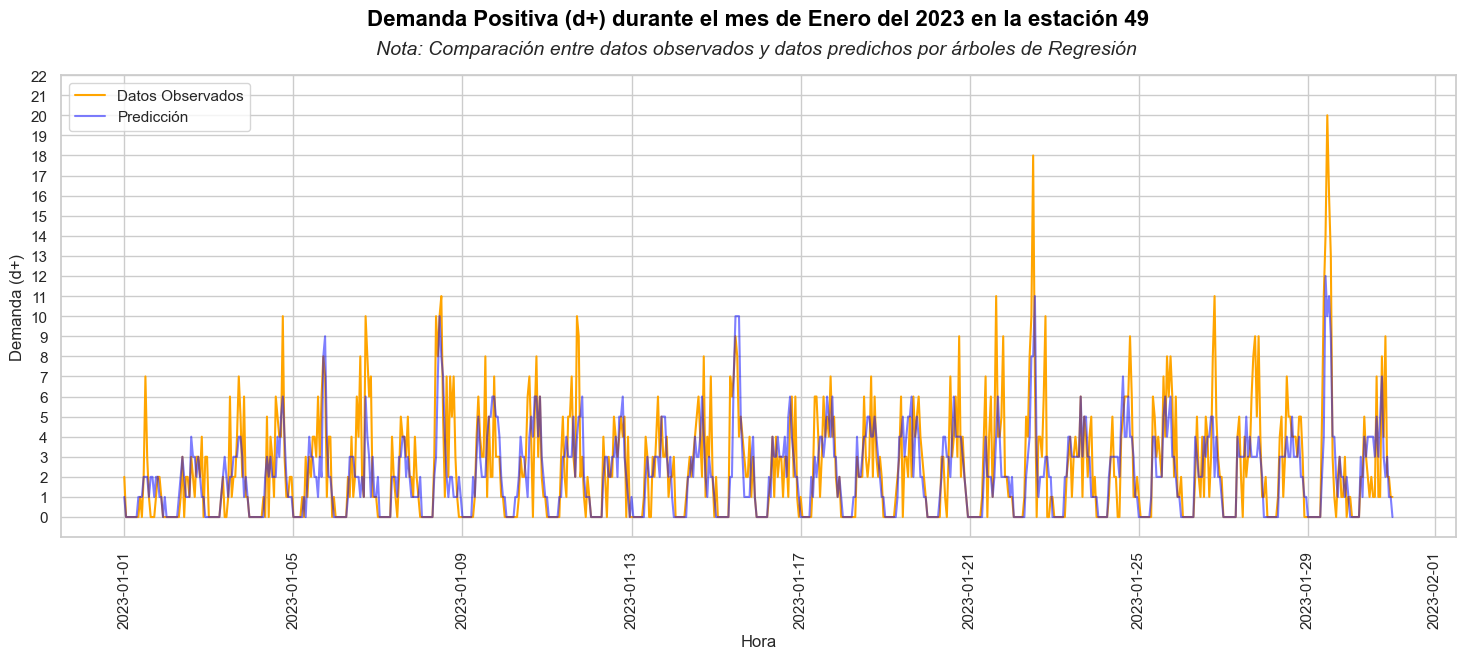

In [59]:
import seaborn as sns
import matplotlib.pyplot as plt

# Blue
sns.set(style="whitegrid") # darkgrid whitegrid

plt.figure(figsize=(18, 6))
fig, ax = plt.subplots(1, 1, figsize = (18, 6))
ax = sns.lineplot(x='Hour', y='Count', data=ye2023[:721], label='Datos Observados',color='orange')

# Orange
sns.lineplot(x='Hour', y='Count',data=prediction_df[:721], label='Predicción',alpha = 0.5 ,color='blue', ax=ax)

#plt.title(f'Demanda Positiva (d+) durante el mes de Enero del 2023 en la estación {49}')

plt.title(
    "Demanda Positiva (d+) durante el mes de Enero del 2023 en la estación 49",
    color='black',
    fontsize=16,
    #loc='center',
    fontweight='bold',
    style='normal',
    family='Arial',
    y=1.09)

# Subtítulo de gráfico

nota = 'Nota: Comparación entre datos observados y datos predichos por árboles de Regresión'                                           

n = ''
fig.text(0.3, 0.915, nota, 
         ha='left', fontsize=14, style ='italic', family='Arial')

sns.set(style="darkgrid")

plt.xlabel('Hora')
plt.ylabel('Demanda (d+)')

ax.set_yticks(list(range(0, int(max(ye2023['Count'])+1))))

ax.set_xticklabels(ax.get_xticklabels(), rotation=90)

plt.savefig('demanda_positiva.png', dpi=300)
plt.show()


In [49]:
metrics(df)

Training Set Performance:
Mean Absolute Error (MAE): 0.44571991859577714
Mean Squared Error (MSE): 0.47794283897227163
Root Mean Squared Error (RMSE): 0.6913341008313358

Test Set Performance:
Mean Absolute Error (MAE): 1.2116327568667344
Mean Squared Error (MSE): 3.399506917599186
Root Mean Squared Error (RMSE): 1.8437751808718943


<Figure size 1800x600 with 0 Axes>

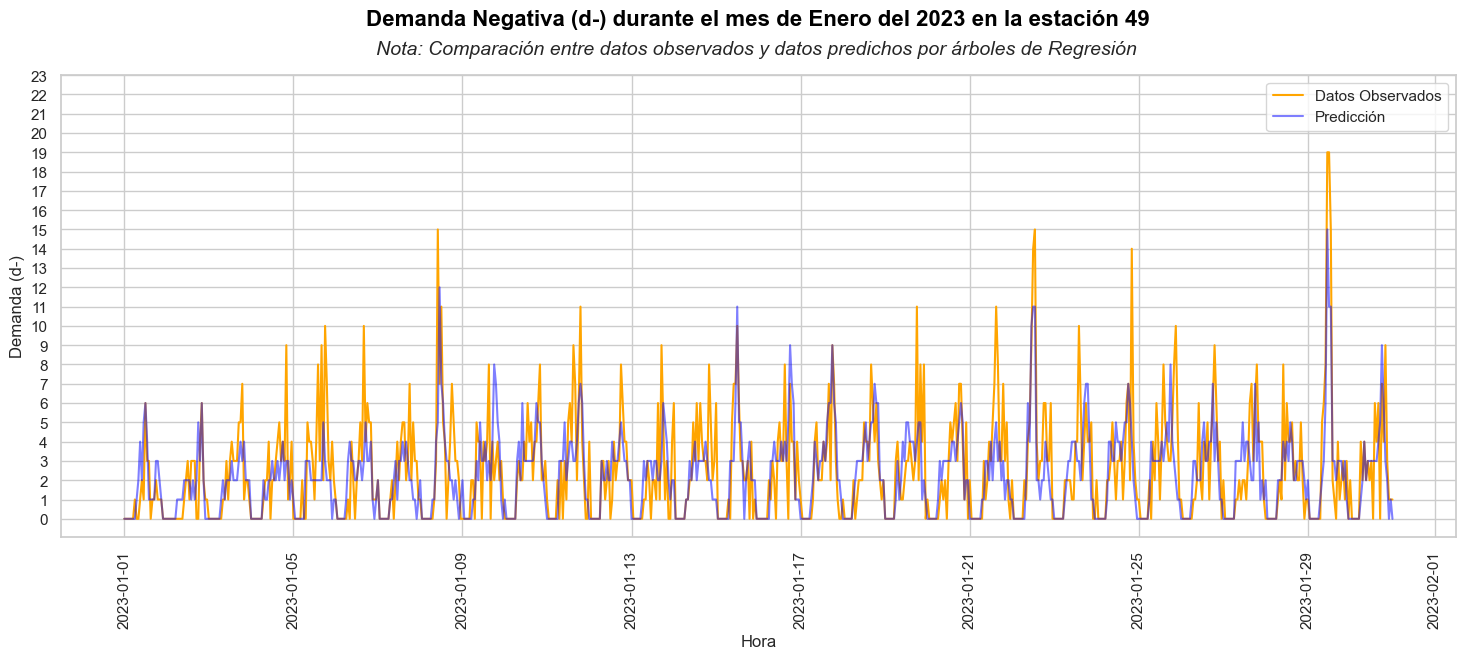

In [60]:
import seaborn as sns
import matplotlib.pyplot as plt

# Blue
sns.set(style="whitegrid") # darkgrid whitegrid

plt.figure(figsize=(18, 6))
fig, ax = plt.subplots(1, 1, figsize = (18, 6))
ax = sns.lineplot(x='Hour', y='Count', data=ye2023_negative[:721], label='Datos Observados',color='orange')

# Orange
sns.lineplot(x='Hour', y='Count',data=prediction_df_negative[:721], label='Predicción',alpha = 0.5 ,color='blue', ax=ax)

#plt.title(f'Demanda Positiva (d+) durante el mes de Enero del 2023 en la estación {49}')

plt.title(
    "Demanda Negativa (d-) durante el mes de Enero del 2023 en la estación 49",
    color='black',
    fontsize=16,
    #loc='center',
    fontweight='bold',
    style='normal',
    family='Arial',
    y=1.09)

# Subtítulo de gráfico

nota = 'Nota: Comparación entre datos observados y datos predichos por árboles de Regresión'                                              

n = ''
fig.text(0.3, 0.915, nota, 
         ha='left', fontsize=14, style ='italic', family='Arial')

sns.set(style="darkgrid")

plt.xlabel('Hora')
plt.ylabel('Demanda (d-)')

ax.set_yticks(list(range(0, int(max(ye2023_negative['Count'])+1))))

ax.set_xticklabels(ax.get_xticklabels(), rotation=90)
plt.savefig('demanda_negativa.png', dpi=300)
plt.show()


In [50]:
metrics(df2)

Training Set Performance:
Mean Absolute Error (MAE): 0.48161409310607983
Mean Squared Error (MSE): 0.5389604807936912
Root Mean Squared Error (RMSE): 0.7341392788794856

Test Set Performance:
Mean Absolute Error (MAE): 1.306447100712106
Mean Squared Error (MSE): 3.8500703204476094
Root Mean Squared Error (RMSE): 1.9621596062623472
